In [28]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from pathlib import Path

# 1 Choosing Dataset

In [38]:
datasets = ['ml-1m', 'steam', 'goodreads']
DATASET = datasets[2]

print(f"Using dataset: {DATASET}")

base_artifacts = Path.cwd().resolve().parents[1] / 'CausalI2I_artifacts'
raw_results = pd.read_csv(base_artifacts / 'Datasets' / 'Evaluated' / f'{DATASET}_evaluated.csv')

Using dataset: goodreads


# 2 Main Analysis

In [30]:
new_names = {
    'cosine_similarity': 'Cosine',
    'correlation': 'Pearson',
    'diff_of_conditionals': 'DoC',
    'jacard_index': 'Jaccard',
    'sasrec_score': 'SASRec'
}
raw_results = raw_results.rename(columns=new_names)

raw_results['STE'] = raw_results[['ATE', 'STD']].apply(lambda row: row['ATE'] / row['STD'] if row['STD'] != 0 else 0, axis=1)
raw_results['ABLT/STD'] = raw_results[['ABLT', 'STD_ABLT']].apply(lambda row: row['ABLT'] / row['STD_ABLT'] if row['STD_ABLT'] != 0 else 0, axis=1)

baselines = ["ATE", "STE", "ABLT", "ABLT/STD", "Cosine", "Pearson", "DoC", "Jaccard", "SASRec"]

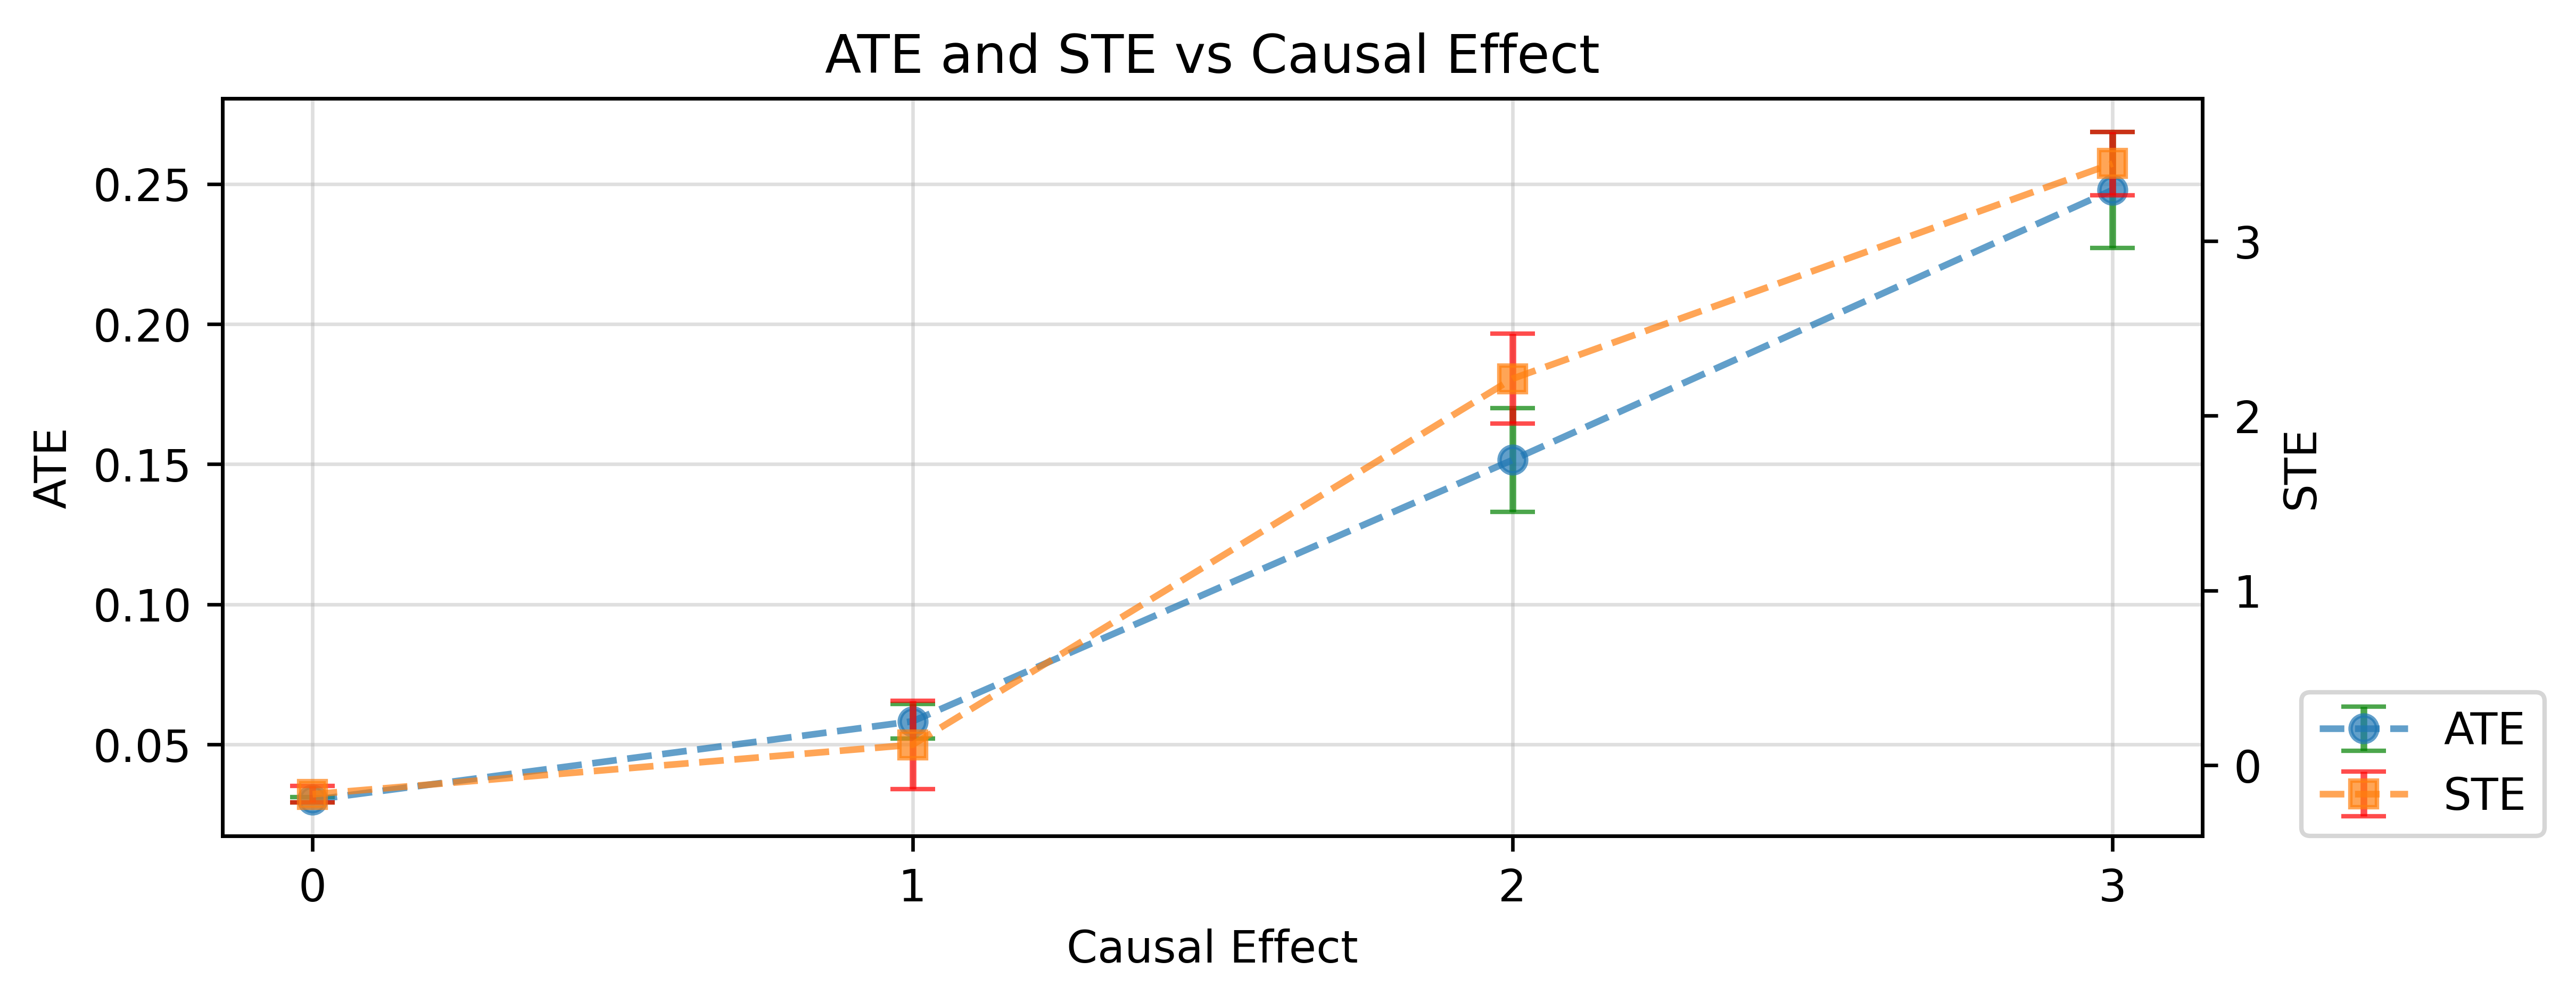

In [31]:
z = norm.ppf(0.95)

fig, ax1 = plt.subplots(figsize=(8, 3), dpi=600)
ax2 = ax1.twinx()

colors = {
    "ATE": "tab:blue",
    "STE": "tab:orange"
}

# ---- ATE (left y-axis) ----
temp_ate = raw_results.groupby('causal_effect')['ATE'].agg(['mean', 'std', 'count'])
ax1.errorbar(
    x=temp_ate.index,
    y=temp_ate['mean'],
    yerr=z * temp_ate['std'] / np.sqrt(temp_ate['count']),
    label='ATE',
    color=colors['ATE'],
    ecolor='green',
    capsize=5,
    elinewidth=1.5,
    marker='o',
    linestyle='--',
    alpha=0.7
)

# ---- STE (right y-axis) ----
temp_ste = raw_results.groupby('causal_effect')['STE'].agg(['mean', 'std', 'count'])
ax2.errorbar(
    x=temp_ste.index,
    y=temp_ste['mean'],
    yerr=z * temp_ste['std'] / np.sqrt(temp_ste['count']),
    label='STE',
    color=colors['STE'],
    ecolor='red',
    capsize=5,
    elinewidth=1.5,
    marker='s',
    linestyle='--',
    alpha=0.7
)

# Labels & styling
ax1.set_xlabel('Causal Effect')
ax1.set_ylabel('ATE')
ax2.set_ylabel('STE')

ax1.set_xticks(range(4))
ax1.grid(alpha=0.4)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc=(1.05, 0))

plt.title('ATE and STE vs Causal Effect')

plt.savefig(
    base_artifacts / 'Figures' / DATASET / 'ate_ste_vs_causal_effect.png',
    bbox_inches='tight'
)
plt.show()

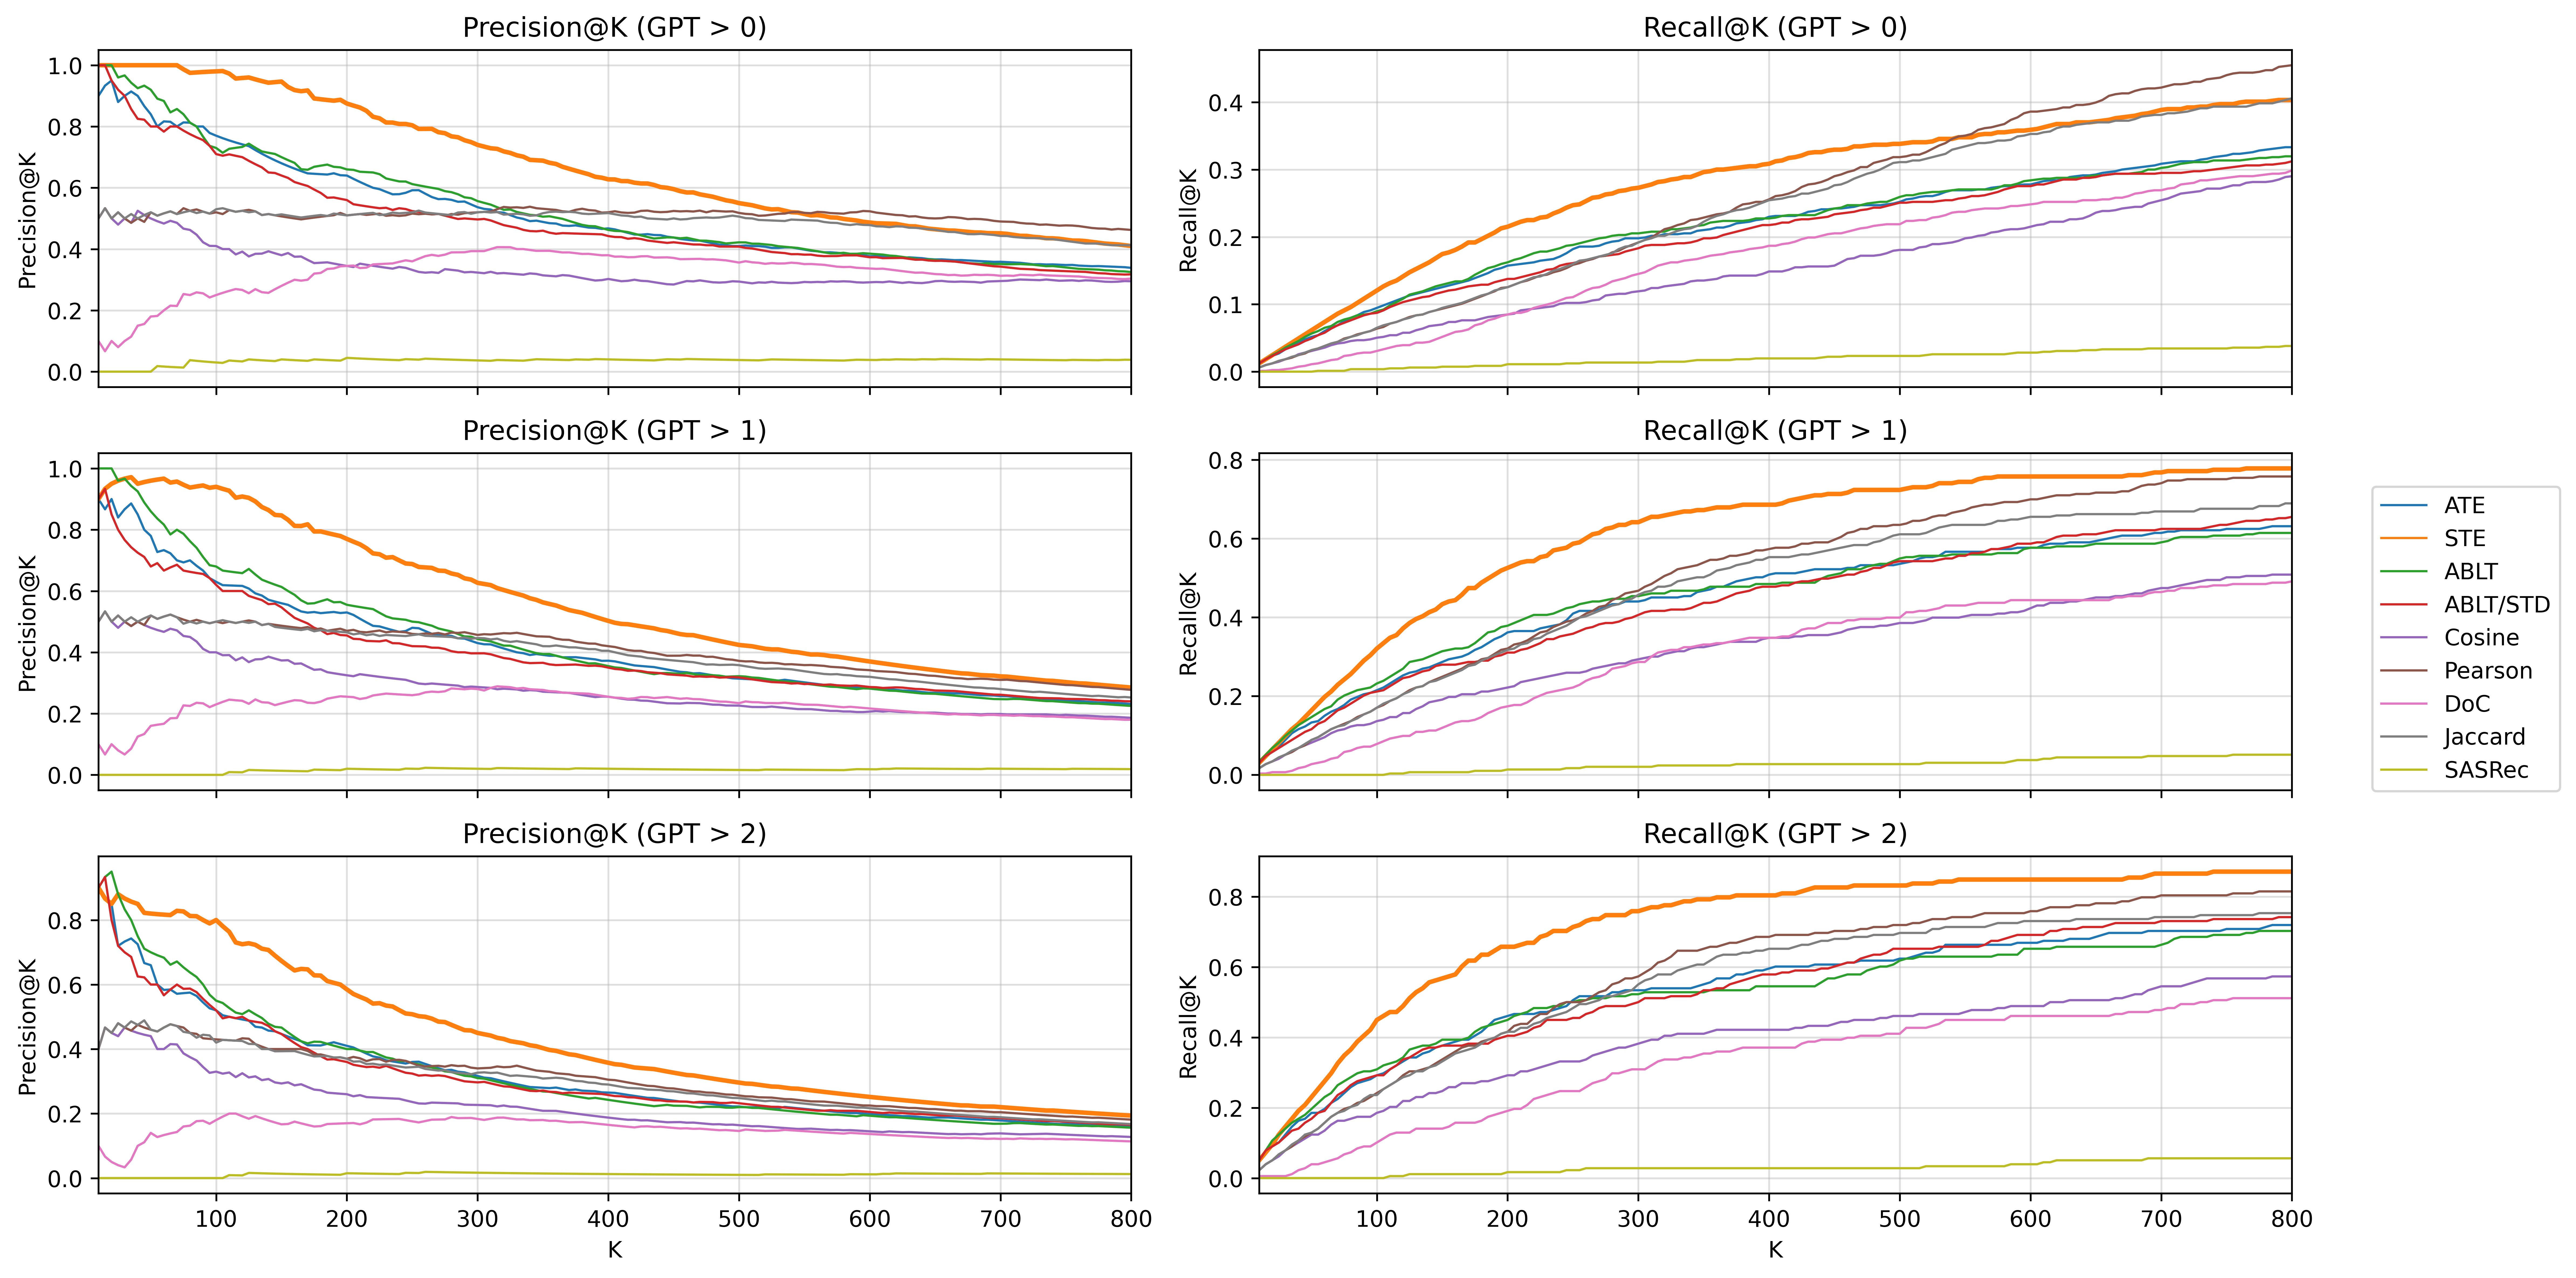

In [32]:
Ks = np.arange(10, 801, step=5)

fig, axes = plt.subplots(
    3, 2,
    figsize=(14.5, 8),
    dpi=600,
    sharex=True
)

for GPT in range(3):
    # Ground truth
    y_true = raw_results['causal_effect'] > GPT
    total_positives = y_true.sum()

    # Store curves + mean scores
    precision_curves = {}
    recall_curves = {}
    mean_precision = {}
    mean_recall = {}

    # ---- compute curves ----
    for col in baselines:
        col_ser = raw_results.sort_values(by=col, ascending=False)['causal_effect']
        causal_link = col_ser > GPT

        precision_vals = np.array([
            causal_link[:K].sum() / K
            for K in Ks
        ])

        recall_vals = np.array([
            causal_link[:K].sum() / total_positives
            for K in Ks
        ])

        precision_curves[col] = precision_vals
        recall_curves[col] = recall_vals

        mean_precision[col] = precision_vals.mean()
        mean_recall[col] = recall_vals.mean()

    # ---- select best baselines (by mean) ----
    best_precision_col = max(mean_precision, key=mean_precision.get)
    best_recall_col = max(mean_recall, key=mean_recall.get)

    # ---- plot Precision@K ----
    for col in baselines:
        axes[GPT, 0].plot(
            Ks,
            precision_curves[col],
            linewidth=2 if col == best_precision_col else 1,
            label=col
        )

    # ---- plot Recall@K ----
    for col in baselines:
        axes[GPT, 1].plot(
            Ks,
            recall_curves[col],
            linewidth=2 if col == best_recall_col else 1,
            label=col
        )

    # ---- formatting ----
    axes[GPT, 0].set_title(f"Precision@K (GPT > {GPT})")
    axes[GPT, 1].set_title(f"Recall@K (GPT > {GPT})")

    axes[GPT, 0].set_ylabel("Precision@K")
    axes[GPT, 1].set_ylabel("Recall@K")

    for j in range(2):
        axes[GPT, j].grid(alpha=0.4)
        axes[GPT, j].set_xlim([Ks[0], Ks[-1]])

# ---- x labels only on bottom row ----
axes[-1, 0].set_xlabel("K")
axes[-1, 1].set_xlabel("K")

# ---- shared legend ----
legend_handles = [
    Line2D(
        [0], [0],
        color=axes[0, 0].lines[i].get_color(),
        lw=1,
        label=label
    )
    for i, label in enumerate(baselines)
]

fig.legend(
    handles=legend_handles,
    labels=baselines,
    bbox_to_anchor=(1.01, 0.5),
    loc="center left"
)

plt.tight_layout()
plt.savefig(
    base_artifacts / 'Figures' / DATASET / 'precision_recall_at_k.png',
    bbox_inches='tight'
)
plt.show()

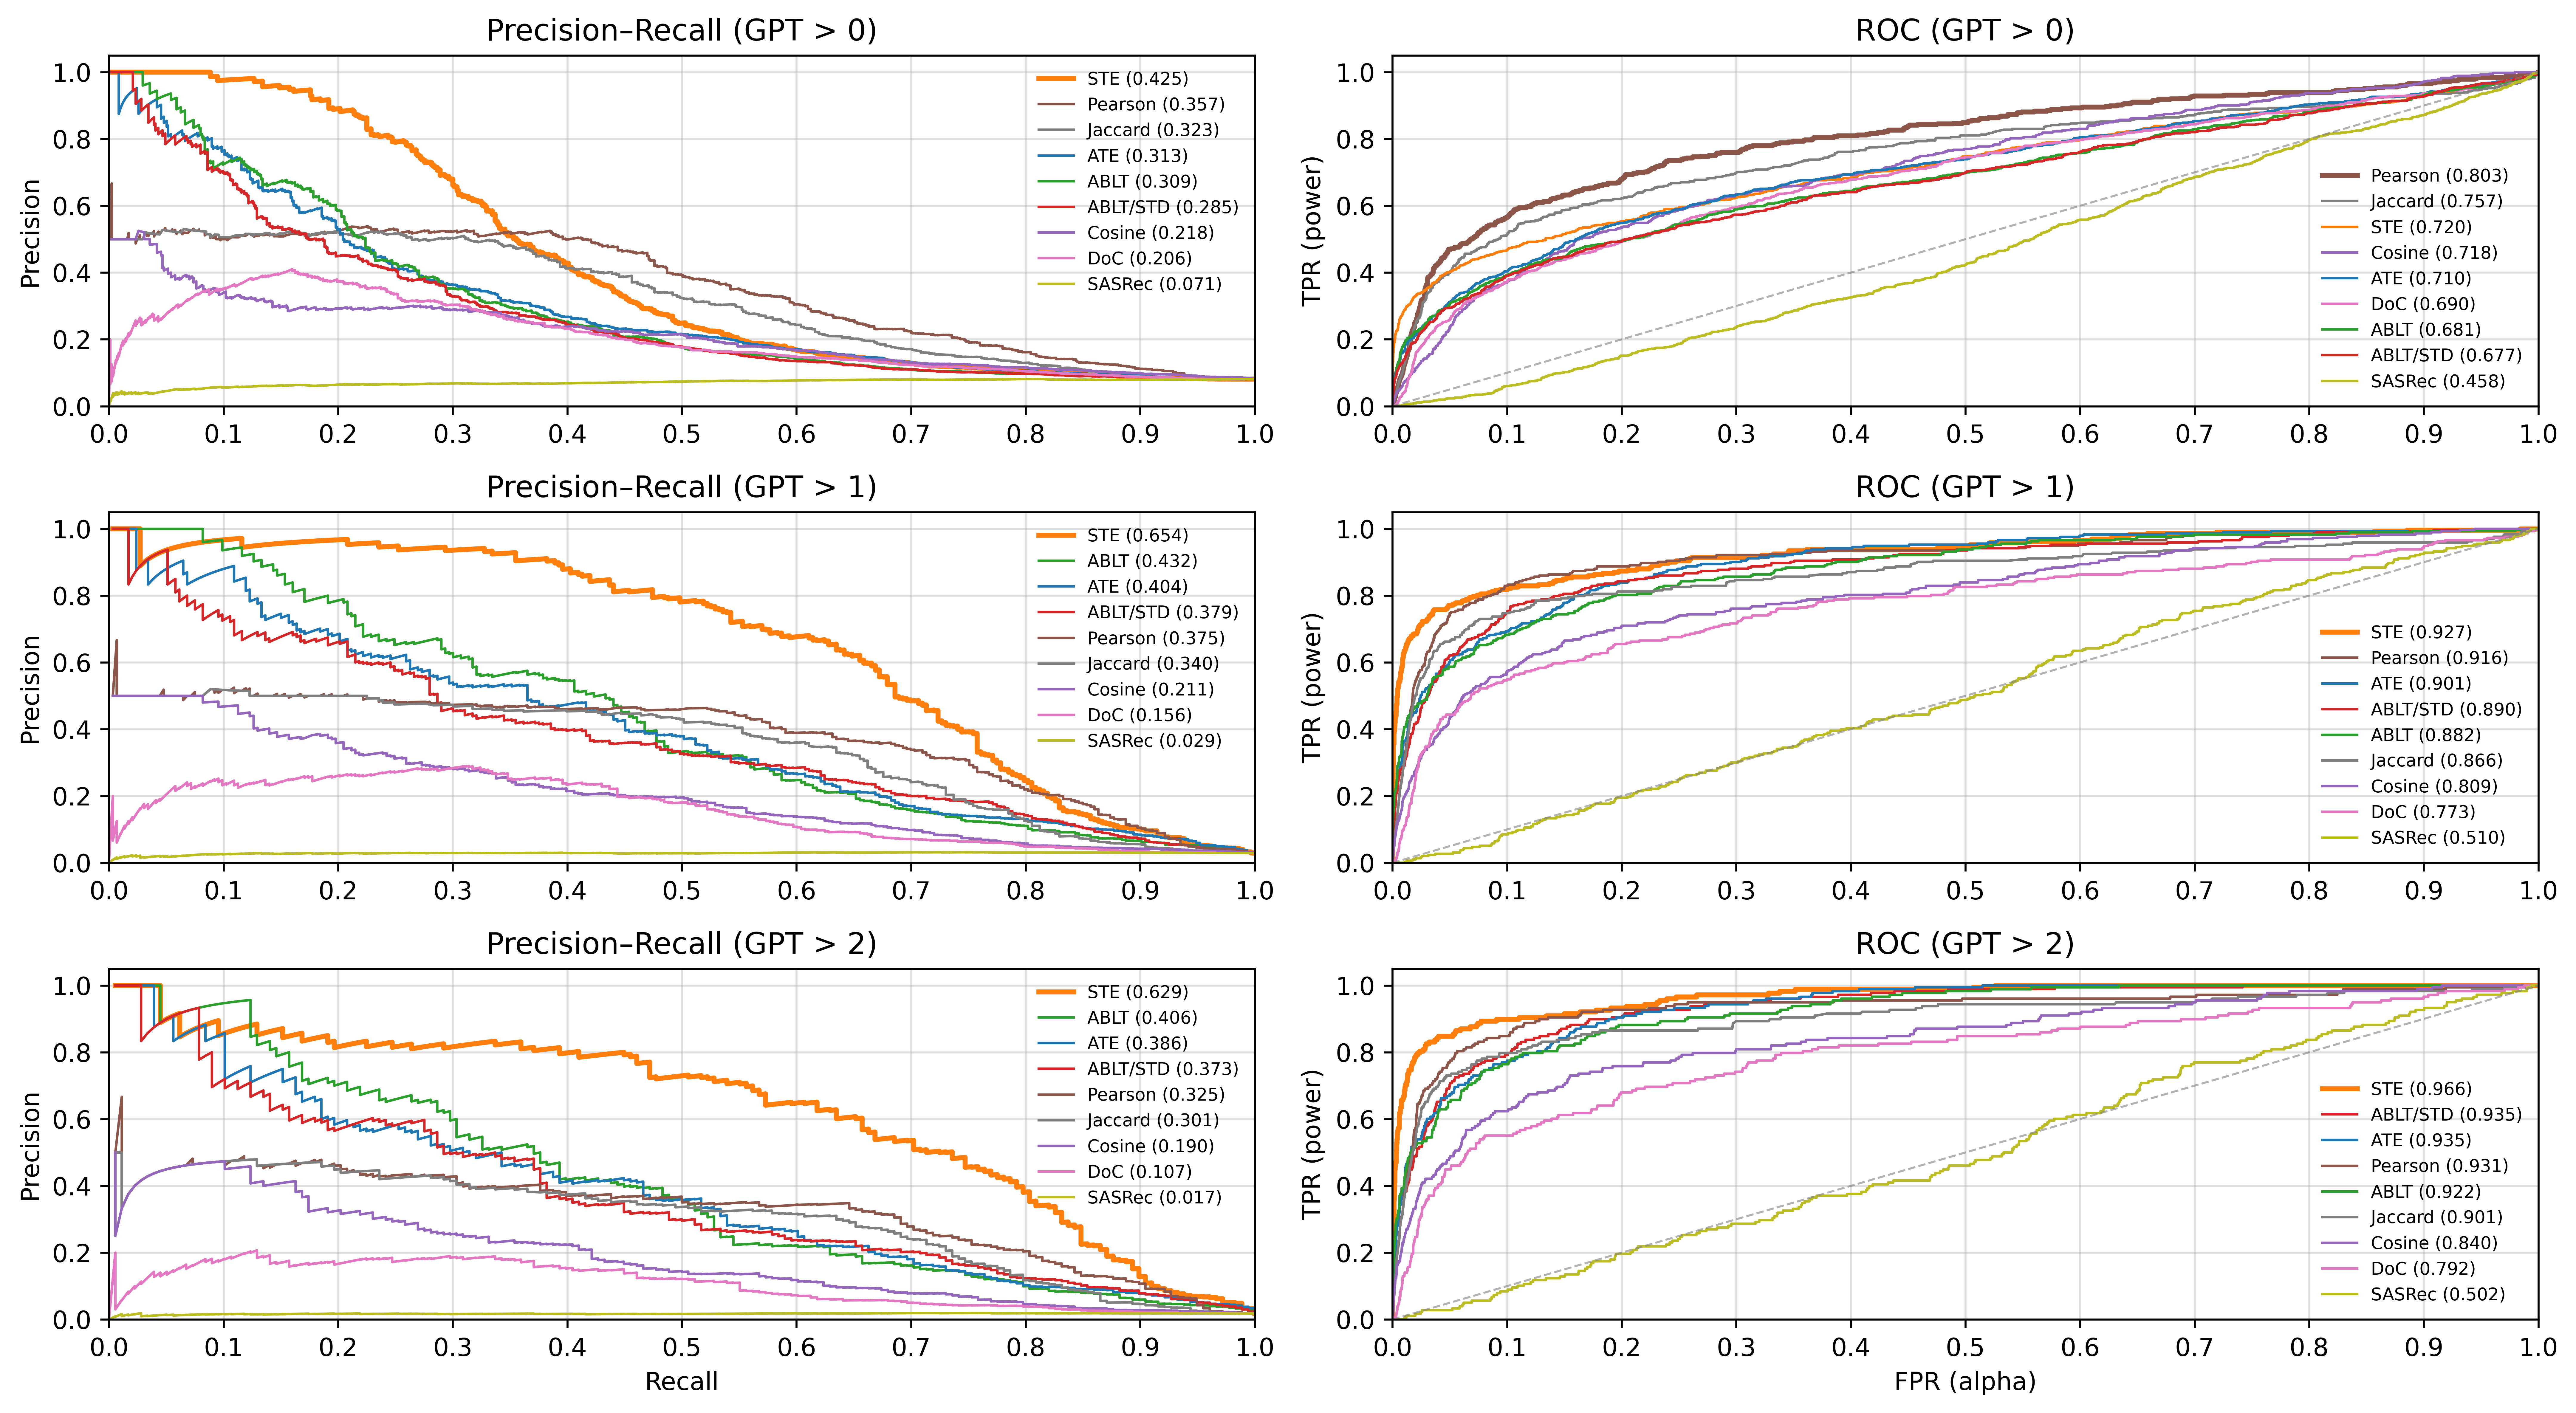

Average Precision                 ROC-AUC                
                     GPT>0   GPT>1   GPT>2   GPT>0   GPT>1   GPT>2
ATE                 31.29%  40.44%  38.57%  71.04%  90.06%  93.49%
STE                 42.49%  65.37%  62.88%  72.02%  92.70%  96.57%
ABLT                30.89%  43.18%  40.61%  68.14%  88.21%  92.22%
ABLT/STD            28.49%  37.86%  37.27%  67.66%  89.04%  93.51%
Cosine              21.79%  21.10%  19.01%  71.84%  80.92%  84.02%
Pearson             35.66%  37.55%  32.46%  80.30%  91.61%  93.12%
DoC                 20.56%  15.61%  10.73%  69.04%  77.34%  79.23%
Jaccard             32.25%  34.01%  30.05%  75.67%  86.63%  90.15%
SASRec               7.07%   2.90%   1.74%  45.84%  51.05%  50.23%

In [33]:
summary = {col: {} for col in baselines}

# Fixed color assignment (stable across all subplots)
cmap = plt.get_cmap("tab10")  # or tab20 if many baselines
color_map = {
    col: cmap(i % cmap.N)
    for i, col in enumerate(baselines)
}

fig, axes = plt.subplots(3, 2, figsize=(14.5, 8), dpi=600)

for GPT in range(3):
    y_true = (raw_results['causal_effect'] > GPT).astype(int).values

    # --- collect curves + scores first ---
    pr_data = []
    roc_data = []

    for col in baselines:
        y_score = raw_results[col].values

        # Precision–Recall
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        ap = average_precision_score(y_true, y_score)
        summary[col][('Average Precision', f'GPT>{GPT}')] = ap
        pr_data.append((col, recall[:-1], precision[:-1], ap))

        # ROC
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        summary[col][('ROC-AUC', f'GPT>{GPT}')] = auc
        roc_data.append((col, fpr, tpr, auc))

    # --- sort by score ---
    pr_data.sort(key=lambda x: x[3], reverse=True)   # by AP
    roc_data.sort(key=lambda x: x[3], reverse=True)  # by AUC

    # --- plot PR ---
    for rank, (col, recall, precision, ap) in enumerate(pr_data):
        axes[GPT, 0].plot(
            recall,
            precision,
            lw=2 if rank == 0 else 1,
            color=color_map[col],
            label=f"{col} ({ap:.3f})"
        )

    # --- plot ROC ---
    for rank, (col, fpr, tpr, auc) in enumerate(roc_data):
        axes[GPT, 1].plot(
            fpr,
            tpr,
            lw=2 if rank == 0 else 1,
            color=color_map[col],
            label=f"{col} ({auc:.3f})"
        )
    axes[GPT, 1].plot([0, 1], [0, 1], ls="--", lw=0.8, color="grey", alpha=0.6)
    

    # ---- Titles & formatting ----
    axes[GPT, 0].set_title(f"Precision–Recall (GPT > {GPT})")
    axes[GPT, 1].set_title(f"ROC (GPT > {GPT})")

    axes[GPT, 0].set_ylabel("Precision")
    axes[GPT, 1].set_ylabel("TPR (power)")

    for j in range(2):
        axes[GPT, j].set_xlim([0, 1])
        axes[GPT, j].set_ylim([0, None])
        axes[GPT, j].set_xticks(np.arange(0, 1.1, 0.1))
        axes[GPT, j].grid(alpha=0.4)
        axes[GPT, j].legend(fontsize=7, frameon=False)

# Bottom x-labels only
axes[-1, 0].set_xlabel("Recall")
axes[-1, 1].set_xlabel("FPR (alpha)")

plt.tight_layout()
plt.savefig(
    base_artifacts / 'Figures' / DATASET / 'pr_roc_curves.png', 
    bbox_inches='tight'
)
plt.show()

summary_df = pd.DataFrame(summary).T
columns_ordered = summary_df.columns[[0, 2, 4, 1, 3, 5]]
summary_df = summary_df[columns_ordered]
summary_df = summary_df.map(lambda x: f"{x:.2%}")
display(summary_df)

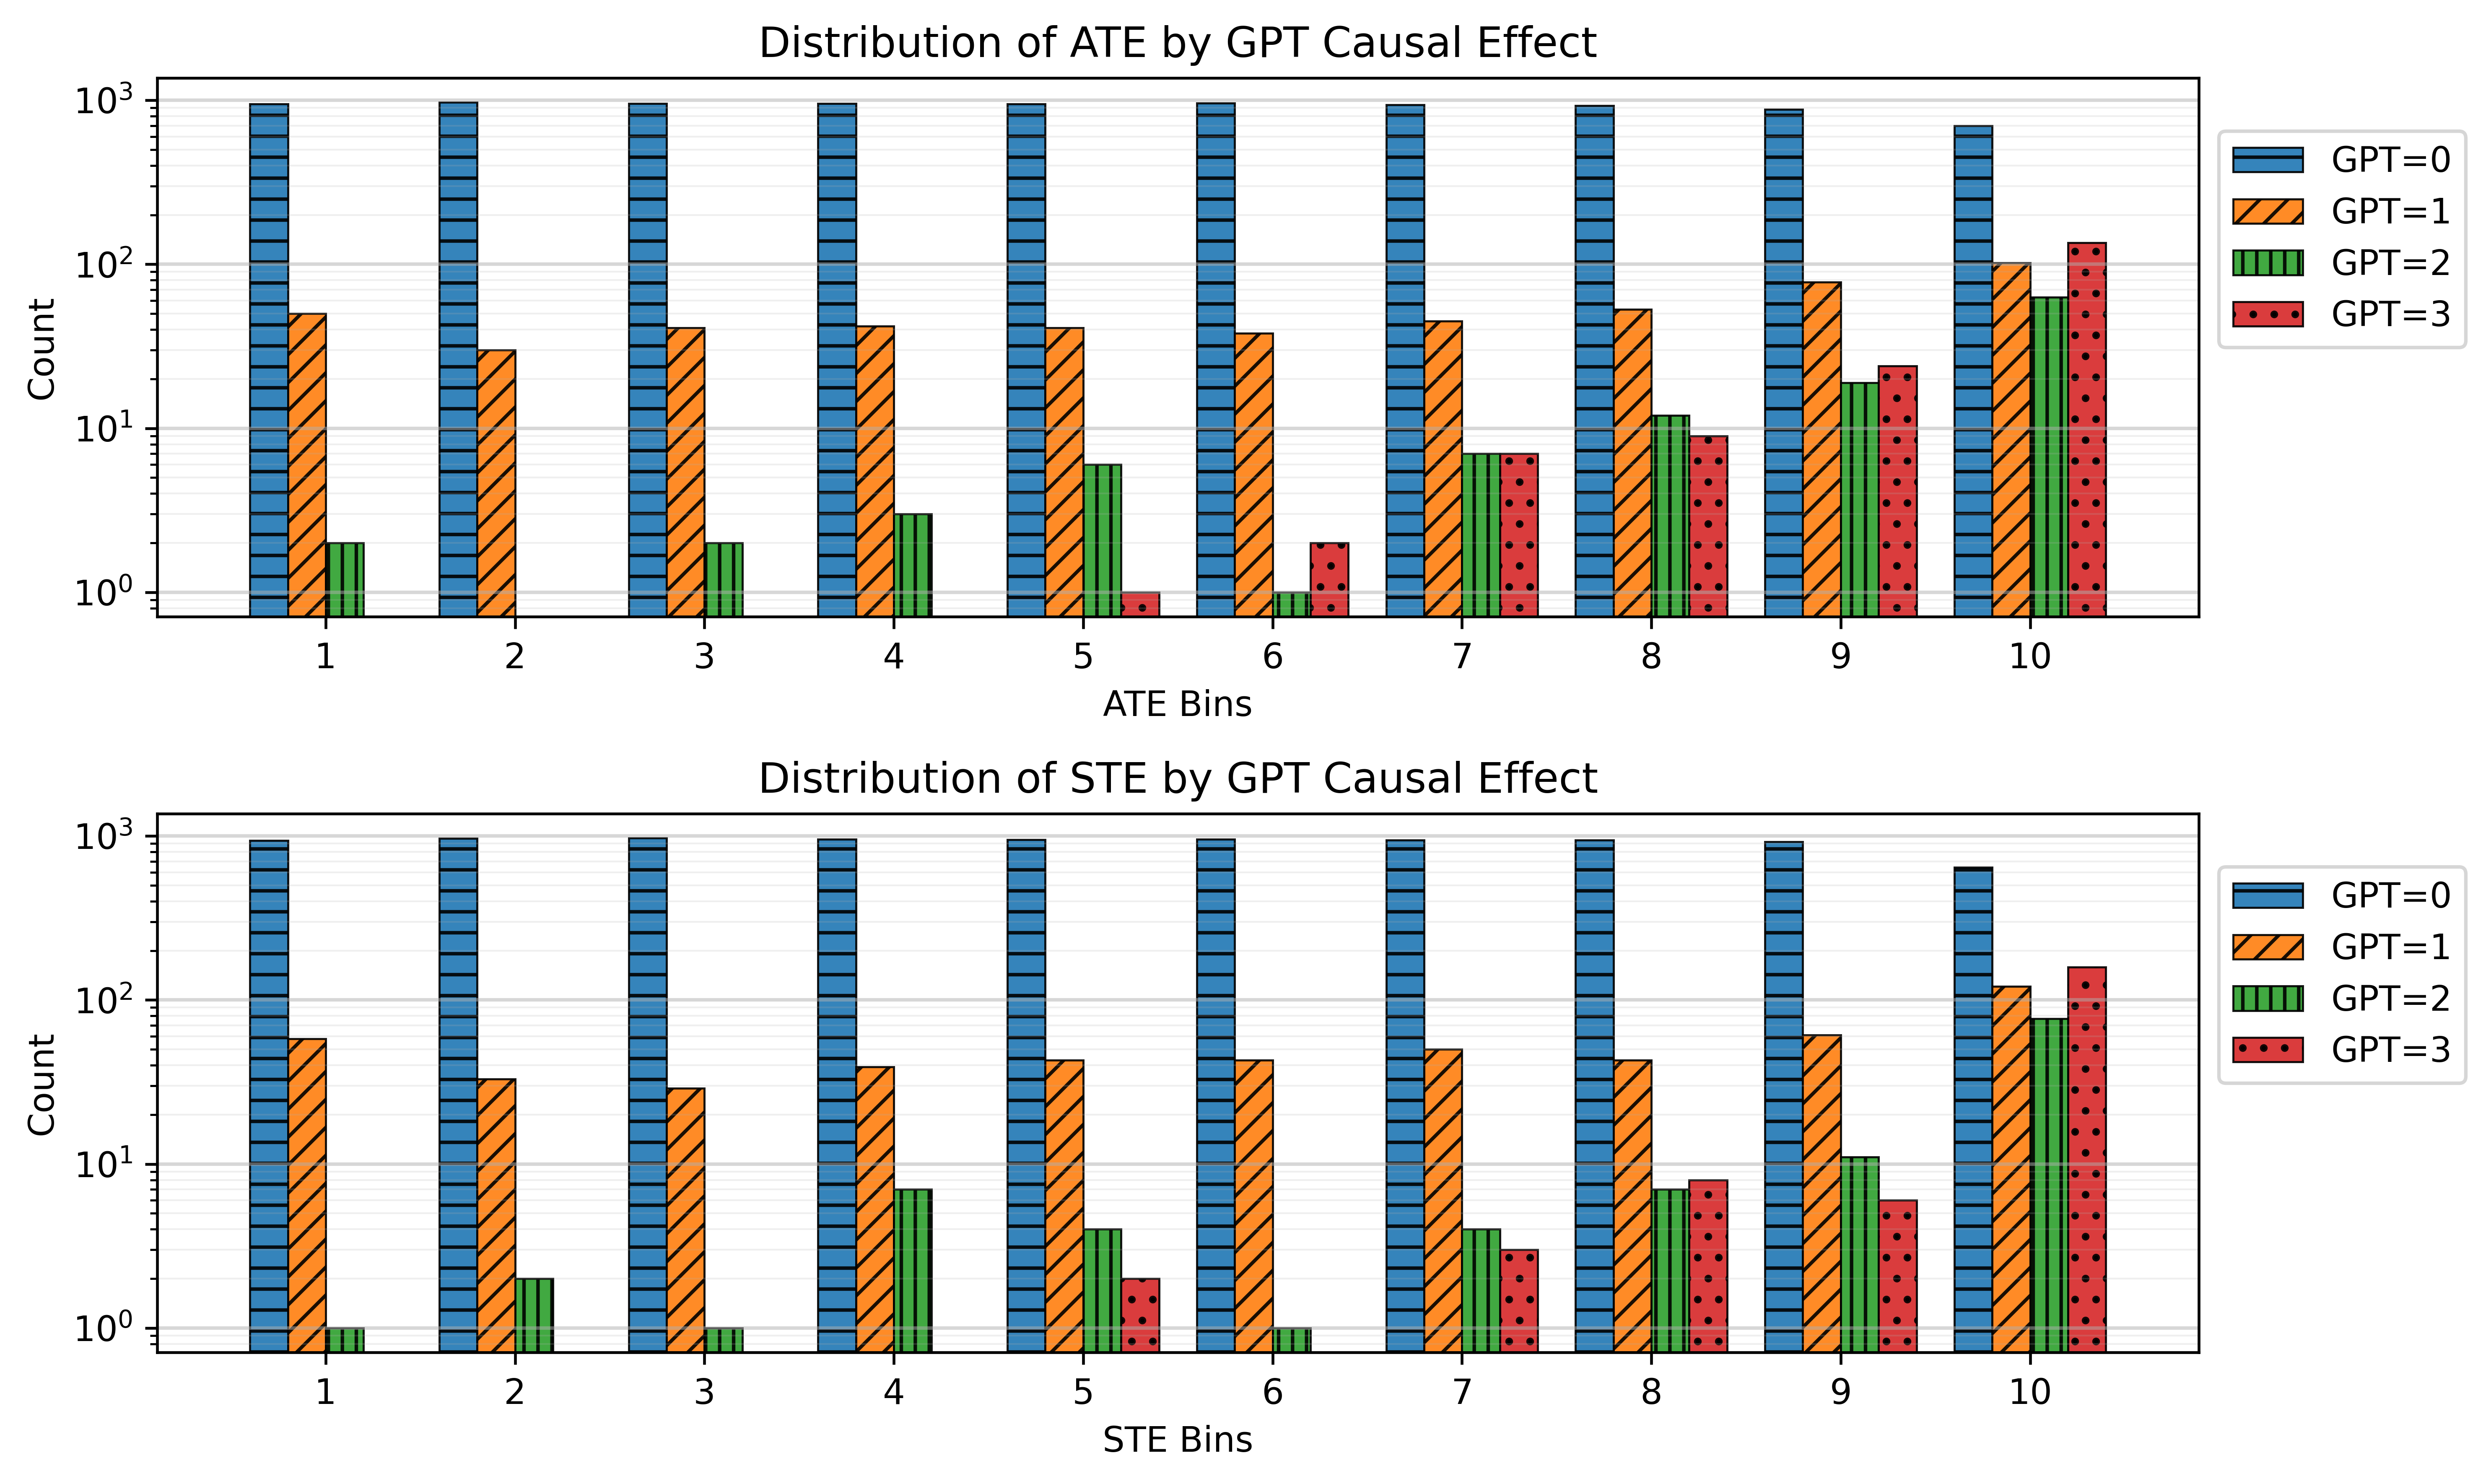

In [34]:
num_bins = 10
w = 0.2

fig, axes = plt.subplots(2, 1, figsize=(10, 6), dpi=600)

hatches = ['--', '///', '|||', '..']   # one per GPT
colors  = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for ax, metric in zip(axes, ["ATE", "STE"]):

    # Quantile bins for the current metric
    bins = np.quantile(
        raw_results[metric].values,
        np.arange(0, 1, 1 / num_bins)
    )

    df = raw_results[[metric, 'causal_effect']].copy()
    df['metric_bin'] = np.digitize(df[metric], bins) - 1

    for GPT in range(4):
        subset = df[df['causal_effect'] == GPT]
        counts = subset['metric_bin'].value_counts().sort_index()

        ax.bar(
            counts.index + (GPT - 1.5) * w,
            counts.values,
            width=w,
            alpha=0.9,
            color=colors[GPT],
            hatch=hatches[GPT],
            edgecolor='black', 
            linewidth=0.6,
            label=f'GPT={GPT}'
        )

    ax.set_xticks(range(num_bins))
    ax.set_xticklabels(range(1, num_bins + 1))
    ax.set_xlabel(f'{metric} Bins')
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {metric} by GPT Causal Effect')
    ax.legend(loc=(1.01, 0.5))

    ax.set_yscale('log')
    ax.grid(axis='y', which='major', alpha=0.5, linewidth=1)
    ax.grid(axis='y', which='minor', alpha=0.2, linewidth=0.5)

plt.tight_layout()
plt.savefig(
    base_artifacts / 'Figures' / DATASET / 'metric_distribution_by_causal_effect.png', 
    bbox_inches='tight'
)
plt.show()

# 3 Further Analysis

In [35]:
summary_dict = {}
for ds in datasets:
    folder = base_artifacts / 'API_Results' / ds
    csvs_in_folder = [p.name for p in folder.iterdir() if p.is_file() and p.suffix == '.csv']
    oracle_file_name = csvs_in_folder[0]
    oracle = pd.read_csv(folder / oracle_file_name)
    summary_dict[ds] = oracle['causal_effect'].value_counts().to_dict()

summary_df = (
    pd.DataFrame(summary_dict)
    .T
    .rename_axis('Dataset', axis=0)
    .rename_axis('Causal Effect', axis=1)
)
summary_df

Causal Effect     0    1    2    3
Dataset                           
ml-1m          9862   84   34   20
steam          9582  286   95   37
goodreads      9187  520  115  178

In [36]:
subset = raw_results[raw_results['causal_effect'] > 0]
print(f'Number of Pairs with Positive GPT Causal Effect: {len(subset)}')

pairs = list(zip(subset['cause_id'], subset['effect_id']))
unique_pairs = pd.Series([sorted(pair) for pair in pairs]).astype(str).unique()

print(f'Number of Unique Pairs with Positive GPT Causal Effect: {len(unique_pairs)}')

Number of Pairs with Positive GPT Causal Effect: 813
Number of Unique Pairs with Positive GPT Causal Effect: 523


Correlation between ATEs of item pairs: -1.60%


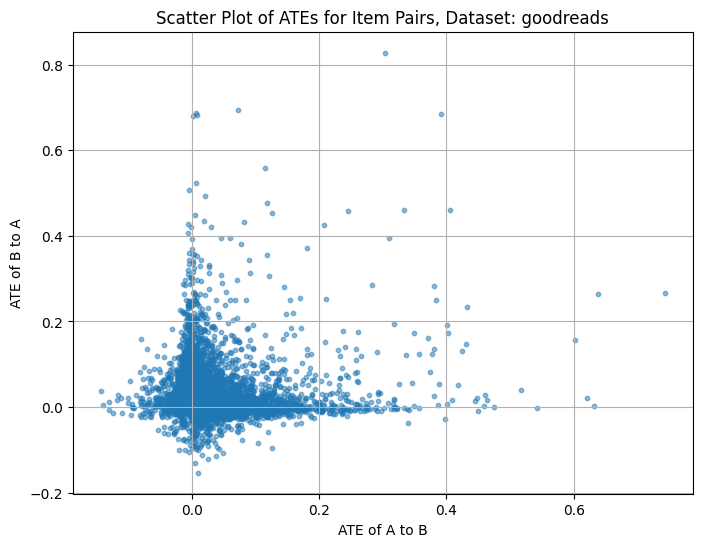

/tmp/ipykernel_1992875/1770444259.py:34: RuntimeWarning: divide by zero encountered in log
  zz = np.maximum(np.log(zz), 0)


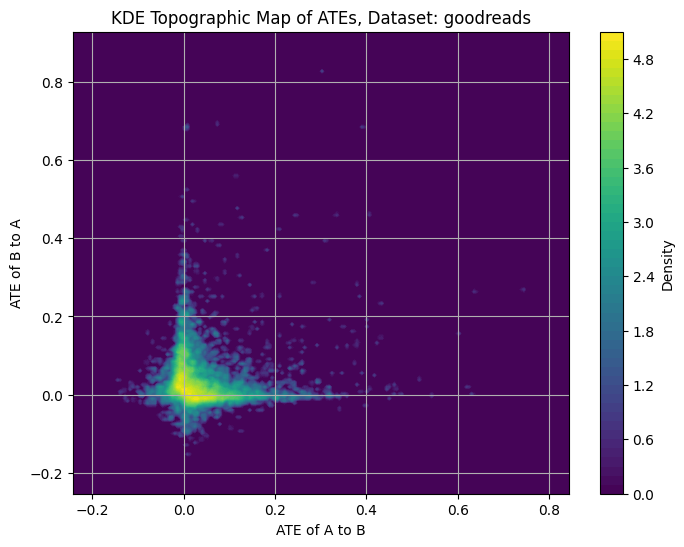

In [37]:
new = raw_results.copy()
new['parity'] = [0, 1] * 5000
new['pair_id'] = [i // 2 for i in range(len(new))]
new = new[['ATE', 'parity', 'pair_id']]
new = new.pivot_table(index='pair_id', columns='parity', values='ATE')

print(f'Correlation between ATEs of item pairs: {np.corrcoef(new[0], new[1])[0, 1]:.2%}')

plt.figure(figsize=(8, 6))
plt.scatter(new[0], new[1], alpha=0.5, s=10)
plt.xlabel('ATE of A to B')
plt.ylabel('ATE of B to A')
plt.title(f'Scatter Plot of ATEs for Item Pairs, Dataset: {DATASET}')
plt.grid()
plt.show()

from scipy.stats import gaussian_kde

x = new[0].values
y = new[1].values

# KDE
kde = gaussian_kde(np.vstack([x, y]), bw_method=0.05)

# Grid
xmin, xmax = x.min()-0.1, x.max()+0.1
ymin, ymax = y.min()-0.1, y.max()+0.1
xx, yy = np.meshgrid(
    np.linspace(xmin, xmax, 200),
    np.linspace(ymin, ymax, 200)
)

zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
zz = np.maximum(np.log(zz), 0)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, zz, levels=50, cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('ATE of A to B')
plt.ylabel('ATE of B to A')
plt.title(f'KDE Topographic Map of ATEs, Dataset: {DATASET}')
plt.grid()
plt.show()
